##Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from pathlib import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [ ]:
train_path = "/content/drive/MyDrive/kaggle_datasets/Skin cancer ISIC The International Skin Imaging Collaboration 4 class/Train"
test_path = "/content/drive/MyDrive/kaggle_datasets/Skin cancer ISIC The International Skin Imaging Collaboration 4 class/Test"

In [ ]:
Labels = ['basal cell carcinoma', 'melanoma', 'nevus', 'pigmented benign keratosis']

In [ ]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 basal cell carcinoma
1 melanoma
2 nevus
3 pigmented benign keratosis


##Data Preprocessing

In [ ]:
module_selection = (224, 1280) 
pixels, FV_SIZE = module_selection
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 128

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=40,
                               shear_range=0.2,
                               zoom_range=0.2,
                               fill_mode='nearest',
                               )

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_ds = train_gen.flow_from_directory(train_path,
                                         class_mode="categorical",
                                         target_size=IMAGE_SIZE,
                                         batch_size=BATCH_SIZE)

valid_ds = val_datagen.flow_from_directory(train_path,
                                         shuffle=False,
                                         class_mode="categorical",
                                         target_size=IMAGE_SIZE,
                                         batch_size=BATCH_SIZE)

test_ds = val_datagen.flow_from_directory(test_path,
                                         shuffle=False,
                                         class_mode="categorical",
                                         target_size=IMAGE_SIZE,
                                         batch_size=BATCH_SIZE)

Found 1661 images belonging to 4 classes.
Found 1661 images belonging to 4 classes.
Found 64 images belonging to 4 classes.


##Modelling

In [ ]:
efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
feature_extractor = hub.KerasLayer(efficient_url,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

print("Building model with", efficient_url)
model_efficient = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(4, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model_efficient.summary()

Building model with https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 4,230,560
Trainable params: 180,996
Non-trainable params: 4,049,564
______________________

In [ ]:
model_efficient.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                          loss=tf.keras.losses.categorical_crossentropy,
                          metrics=['accuracy']
                          )

In [ ]:
callbacksX = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights=True)

history_model_efficient = model_efficient.fit(train_ds,
                                              epochs=60,
                                              validation_data=valid_ds,
                                              verbose=1,
                                              callbacks=callbacksX
                                              )

Epoch 1/60
13/13 [==============================] - 87s 6s/step - loss: 1.2483 - accuracy: 0.4497 - val_loss: 1.1568 - val_accuracy: 0.4997
Epoch 2/60
13/13 [==============================] - 75s 6s/step - loss: 1.0319 - accuracy: 0.5966 - val_loss: 0.9921 - val_accuracy: 0.6171
Epoch 3/60
13/13 [==============================] - 74s 6s/step - loss: 0.8835 - accuracy: 0.6695 - val_loss: 0.8912 - val_accuracy: 0.6623
Epoch 4/60
13/13 [==============================] - 76s 6s/step - loss: 0.8080 - accuracy: 0.6911 - val_loss: 0.8384 - val_accuracy: 0.6653
Epoch 5/60
13/13 [==============================] - 75s 6s/step - loss: 0.7473 - accuracy: 0.7170 - val_loss: 0.8026 - val_accuracy: 0.6905
Epoch 6/60
13/13 [==============================] - 76s 6s/step - loss: 0.7061 - accuracy: 0.7393 - val_loss: 0.7531 - val_accuracy: 0.7116
Epoch 7/60
13/13 [==============================] - 76s 6s/step - loss: 0.6713 - accuracy: 0.7465 - val_loss: 0.7051 - val_accuracy: 0.7345
Epoch 8/60
13/13 [==

##Visualize Data

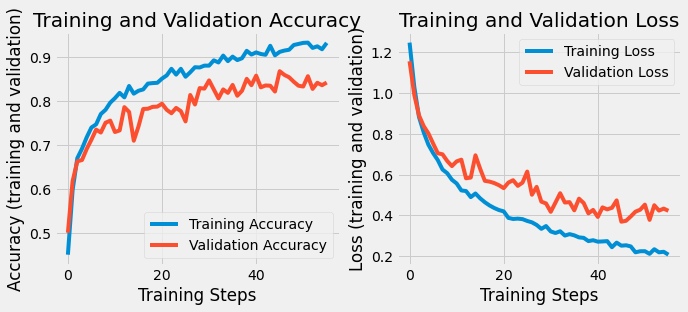

In [ ]:
import matplotlib.pylab as plt
import numpy as np
acc = history_model_efficient.history['accuracy']
val_acc = history_model_efficient.history['val_accuracy']
loss = history_model_efficient.history['loss']
val_loss = history_model_efficient.history['val_loss']
epochs_range = range(56)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

##Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)        
        length=len(classes)
        if length<25:
            if length<8:
                fig_width=8
                fig_height=8
            else:
                fig_width= int(length * .5)
                fig_height= int(length * .5)
            plt.figure(figsize=(fig_width, fig_height))
            sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
            plt.xticks(np.arange(length)+.5, classes, rotation= 90)
            plt.yticks(np.arange(length)+.5, classes, rotation=0)
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix")
            plt.show()    
        print("Classification Report:\n----------------------\n", clr)

13/53 [======>.......................] - ETA: 1:31

53/53 [==============================] - 30s 534ms/step


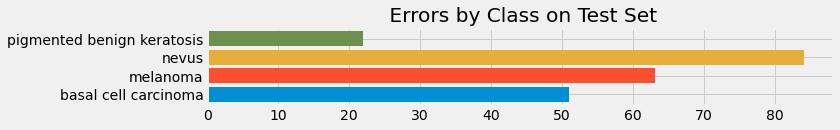

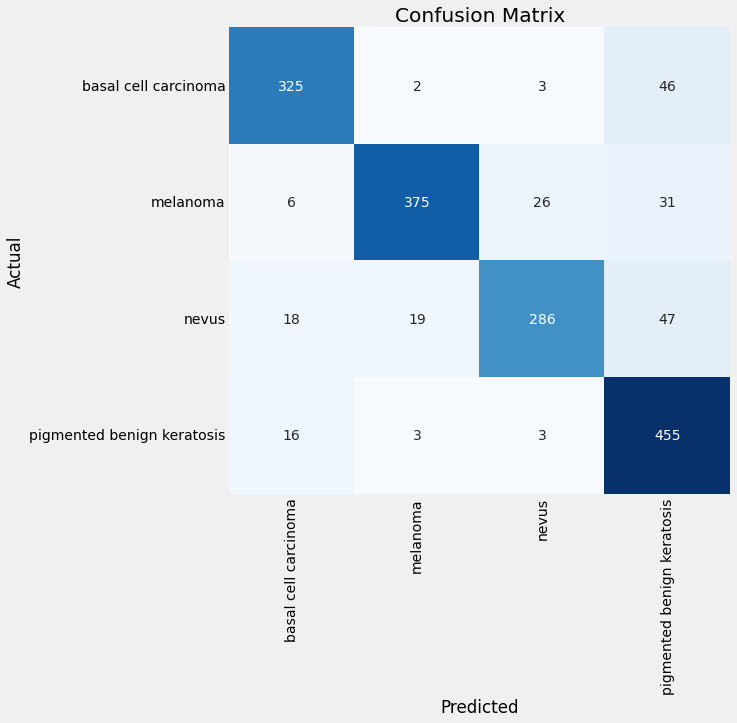

Classification Report:
----------------------
                             precision    recall  f1-score   support

      basal cell carcinoma       0.89      0.86      0.88       376
                  melanoma       0.94      0.86      0.90       438
                     nevus       0.90      0.77      0.83       370
pigmented benign keratosis       0.79      0.95      0.86       477

                  accuracy                           0.87      1661
                 macro avg       0.88      0.86      0.87      1661
              weighted avg       0.88      0.87      0.87      1661



In [ ]:
save_dir=r'./'
subject='skin cancer'
print_code=0
preds=model_efficient.predict(valid_ds, steps=53) 
print_info( valid_ds, preds, print_code, save_dir, subject ) 

##Testing Predict

1/1 [==============================] - 0s 64ms/step
class: melanoma, confidence: 0.628980


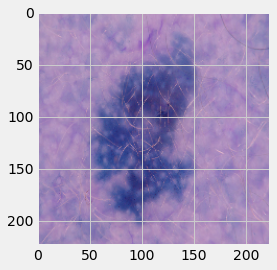

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 48ms/step
class: basal cell carcinoma, confidence: 0.747175


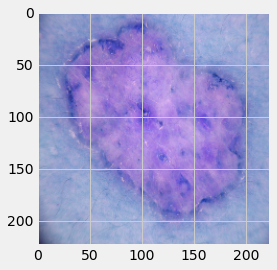

1/1 [==============================] - 0s 54ms/step
class: pigmented benign keratosis, confidence: 0.829283


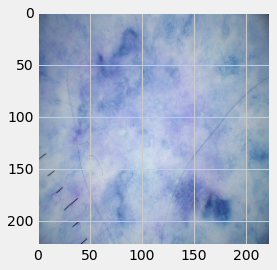

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 43ms/step
class: pigmented benign keratosis, confidence: 0.980943


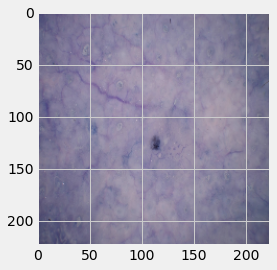

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 25ms/step
class: basal cell carcinoma, confidence: 0.514011


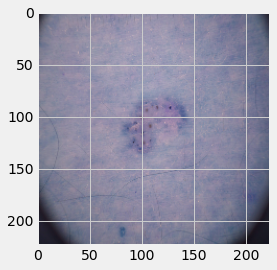

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 22ms/step
class: nevus, confidence: 0.982899


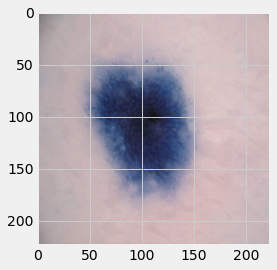

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
class: nevus, confidence: 0.951618


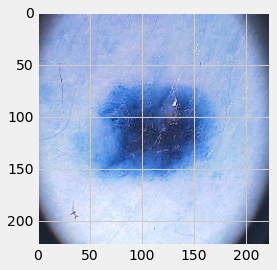

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 22ms/step
class: pigmented benign keratosis, confidence: 0.858115


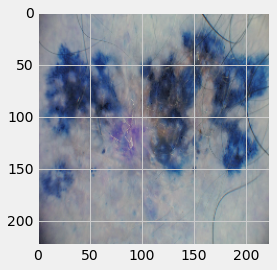

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 22ms/step
class: melanoma, confidence: 0.889774


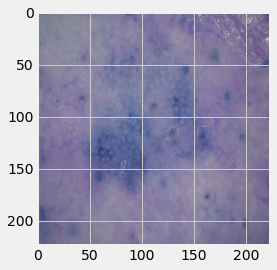

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 21ms/step
class: basal cell carcinoma, confidence: 0.796271


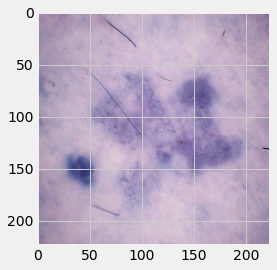

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 23ms/step
class: basal cell carcinoma, confidence: 0.515622


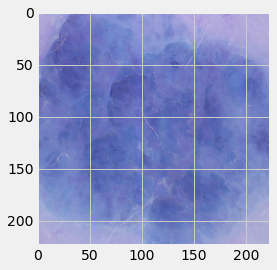

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 22ms/step
class: pigmented benign keratosis, confidence: 0.874274


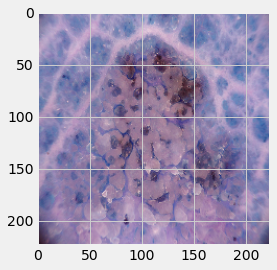

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
class: melanoma, confidence: 0.447888


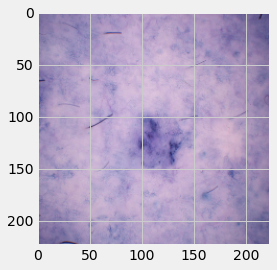

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 27ms/step
class: melanoma, confidence: 0.304642


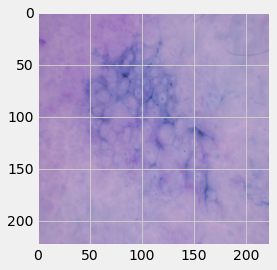

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 22ms/step
class: nevus, confidence: 0.799448


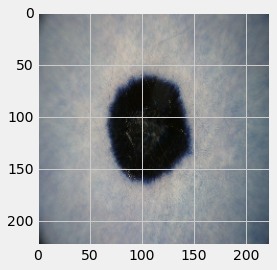

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 27ms/step
class: nevus, confidence: 0.960244


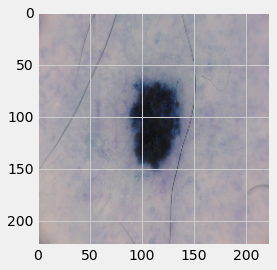

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 29ms/step
class: melanoma, confidence: 0.692934


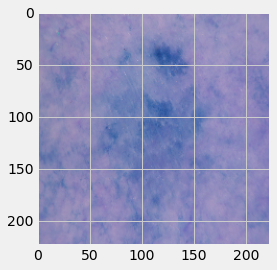

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 21ms/step
class: nevus, confidence: 0.427933


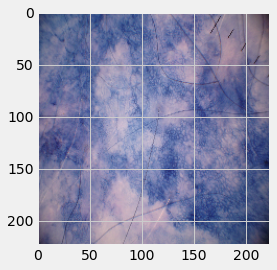

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 22ms/step
class: melanoma, confidence: 0.951741


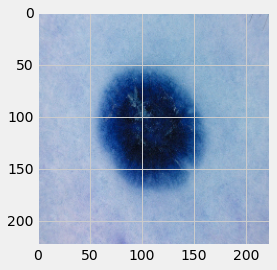

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 31ms/step
class: melanoma, confidence: 0.964941


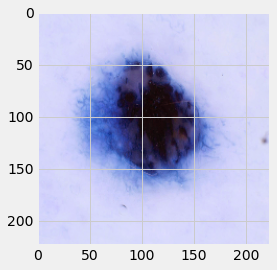

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 31ms/step
class: pigmented benign keratosis, confidence: 0.861504


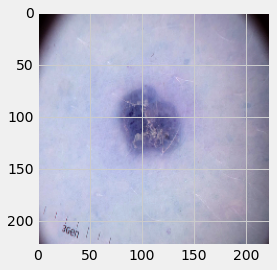

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 31ms/step
class: melanoma, confidence: 0.736676


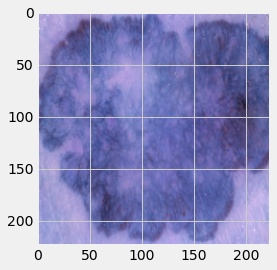

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 36ms/step
class: pigmented benign keratosis, confidence: 0.401335


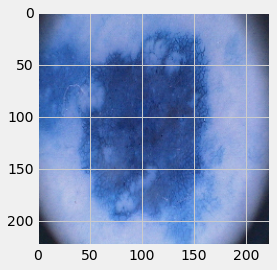

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 34ms/step
class: nevus, confidence: 0.414879


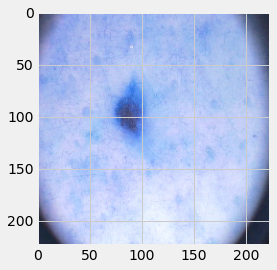

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 31ms/step
class: nevus, confidence: 0.855444


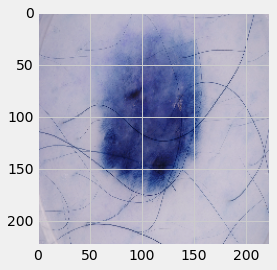

<Figure size 432x288 with 0 Axes>

In [ ]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_path, filename))
    img = cv2.resize(img, (224, 224))
    img = img /255
    return img
def pre_result(image):
    x = model_efficient.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}

images = random.sample(valid_ds.filenames, 25)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

##Modelling Save

In [ ]:
model_efficient.save("model_efficient_terbaru.h5")

In [ ]:
model = tf.keras.models.load_model(
       ('/content/model_efficient_terbaru.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("SCD_model_terbaru.tflite", "wb").write(tflite_model)

16742364